In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import openai
import random
import os
import collections
import copy
import netgraph
import seaborn as sns
import scipy.stats

MEDIUM_SIZE = 18
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


with open('params.json') as f:
    params = json.load(f)

openai.api_key = params['OPENAI_API_KEY']
openai.organization = params['OPENAI_ORG']


def get_response(prompt, model='gpt-3.5-turbo', temperature=0.9, system_prompt="You are mimicking a real-life person who wants to make friends."):
    result = openai.ChatCompletion.create(
    model=model,
    temperature=temperature,
    messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
    ])

    return result.choices[0]['message']['content']

    
def summarize_reasons(filename, n_samples=20, n_categories=4, n_resamples=5, categories=None):
    random.seed(1)
    np.random.seed(1)

    with open(filename) as f:
        lines = f.read().splitlines()


    data = []

    for line in lines:

        data.append(json.loads(line))

    reason_list = collections.defaultdict(list)

    all_reasons = []

    for d in data:        
        for result in d["reasons"]:
            if result and 'reason' in result.keys():
                reason_list[d['temperature']].append(result['reason'])
                all_reasons.append(result['reason'])
    if categories is None:
        categorization_prompt = f"""
        # Task

        You are given a list of reasons and your task to find {n_categories} categories that best describe the reasons.

        # Input

        The input is a list of reasons. The list is given below after chevrons:
        <REASONS>
        {json.dumps(random.sample(all_reasons, len(reason_list) * n_samples))}
        </REASONS>

        # Output

        The output should be given in JSON format with the following structure:

        [
            {{
                "category" : category,
                "description" : short description of the category
            }}, ...
        ]

        # Notes
        * The names of the categories must be descriptive and mutually exclusive.

        ```json
        """

        for _ in range(10):
            try:
                ans = get_response(categorization_prompt, temperature=0, system_prompt="You are a helpful assistant")
                categories = json.loads(ans.split('```')[0])
                print(categories)
                break

            except Exception as e:
                print(e)
        
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    category_list = [c['category'] for c in categories]

    records = []

    for i, (k, v) in enumerate(reason_list.items()):
        print('Temperature', k)
        if len(v) <= n_samples:
            n_resamples = 1

        for r in range(n_resamples):
            prompt = f"""
            # Task
            You are given a list of reasons and your task is to classify them into categories.

            # Input
            The input is a list of reasons. The list is given below after chevrons:
            <REASONS>
            {json.dumps(random.sample(v, n_samples), indent=4)}
            </REASONS>

            ## Categories
            The names of the categories are given below after chevrons:
            <CATEGORIES>
            {json.dumps(categories, indent=4)}
            </CATEGORIES>

            Each reason must be assigned to exactly one of the categories.
            
            # Output
            The output should be given as a list of JSON objects with the following structure:

            [
                {{
                        "reason" : reason,
                        "category" : category name
                }}, ...
            ]

            ```json
            """

            for _ in range(10):
                try:
                    ans = get_response(prompt, temperature=0, system_prompt="You are a helpful assistant")

                    result = json.loads(ans.split('```')[0])

                    assert(isinstance(result, list))

                    reason_types = collections.defaultdict(float)

                    total = 0

                    for reason in result:
                        if reason['category'] in category_list:
                            reason_types[reason['category']] += 1
                            total += 1

                    for key, val in reason_types.items():
                        reason_types[key] = val / total * 100

                   
                    break
                except Exception as e:
                    print(e)

            for key, val in reason_types.items():
                records.append({
                    'Temperature' : k,
                    'Category' : key,
                    'Frequency' : val,
                    'Resample' : r
                })

    
    df = pd.DataFrame.from_records(records)

    fig.suptitle('Reasoning for Principle 5', fontsize=MEDIUM_SIZE)

    sns.barplot(data=df, x='Category', y='Frequency', hue='Temperature', ax=ax, palette='Set2')

    plt.legend(fontsize=0.75*SMALL_SIZE, title='Temperature')

    plt.xticks(rotation=0, fontsize=0.75*SMALL_SIZE)

    fig.tight_layout()

    fig.savefig(f'figures/principle_4/principle_4_reasons.png', dpi=300, bbox_inches='tight')

def print_reasons(filename):
    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:

        data.append(json.loads(line))

    for d in data:
        if d["n"] == 50 and d["simulation"] == 0:
            print(f'n = {d["n"]}, simulation = {d["simulation"]}, temperature = {d["temperature"]}')
            print(d['reasons'])

def barrat_weight_clustering_coefficient(G):

    triangles = 0
    triples = 0

    for node in G.nodes():
        for neighbor in G.neighbors(node):
            for neighbor2 in G.neighbors(neighbor):
                if neighbor2 in G.neighbors(node):
                    triangles += 1

                triples += 1

    return triangles / triples

def fit_beta_ws(G, k, method='binary_search', tol=0.01):
    if method == 'closed_form':
        C = barrat_weight_clustering_coefficient(G)
        C0 = 3 * (k - 1) / (2 * (2 * k - 1))
        return 1 - (C / C0)**(1 / 3)
    
    elif method == 'binary_search':

        beta_max = 1
        beta_min = 0.01

        n = len(G)

        C = nx.average_clustering(G)


        while True:
            beta = (beta_max + beta_min) / 2

            Gs_WS, _ = network_growth(n, k, beta, 0, method='W-S')
            G_WS = Gs_WS[-1]

            C_WS = nx.average_clustering(G_WS)

            if abs(C_WS - C) < tol:
                return beta
            elif C_WS < C:
                beta_max = beta
            else:
                beta_min = beta

        return beta

                
def network_growth(n, k, beta, temperature, method='llm'):
    G = nx.Graph()

    # Create ring network
    for i in range(n):
        G.add_node(i)
    
    for i in G.nodes():
        G.add_edge(i, (i + 1) % n)

    for i in G.nodes():
        for j in G.nodes():
            if 0 < abs(i - j) % (n - 1 - k / 2) <= k / 2:
                G.add_edge(i, j)

    Gs = []
    results = []

    for i in G.nodes():
        neighbors = list(G.neighbors(i))
        for j in neighbors:
            if 0 < (j - i) % n <= k / 2:
                if np.random.uniform() <= beta:
                        while True:
                            if method == 'W-S':
                                v = random.choice(list(set(G.nodes())))
                            elif method == 'llm':
                                result = select_neighbor(G, i, temperature)
                                if not result:
                                    break
                                v = result['name']
                                
                            if v != i and v not in G.neighbors(i):
                                if method == 'llm':
                                    results.append(result)
                                G.add_edge(i, v)
                                G.remove_edge(i, j)
                                break     
                       
                        
        Gs.append(G.copy())

    return Gs, results

def select_neighbor(G, t, temperature):
    features = []
    for v in G.nodes():
        if v != t and v not in G.neighbors(t):
            features.append({'name' : v, 'neighbors' : list(G.neighbors(v))})

    prompt = f"""
    # Task
    Your task is to select a person to be friends with.

    # Input
    The input is a list of dictionaries. Each dictionary has two keys: 'name', 'neighbors'.
    'name' is the name of the person, and 'neighbors' is a list of the person's friends.
    The data is given below after chevrons:
    <DEGREES>
    {json.dumps(features, indent=4)}
    </DEGREES>

    # Output
    The output should be given in JSON format with the following structure

    {{
        "name" : name of the person you selected,
        "reason" : reason for selecting the person
    }}

    # Notes
    - The output must be a valid JSON object.

    ```json
    """   

    for i in range(10):
        try:
            result = json.loads(get_response(prompt, temperature=temperature).split('```')[0])
            if result['name'] in G.nodes():    
                print('NEW EDGE', result)
                return result 
        except Exception as e:
            print(e)
      

def run_network_formation_experiment(n_min, n_max, n_step, k, beta, num_simulations, outfile, temperatures, method):
    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['k'], scenario['beta'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')


    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, k, beta, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, k={k}, beta={beta}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, k={k}, beta={beta}, temperature={temperature}')

                    Gs, reasons = network_growth(n, k, beta, temperature=temperature, method=method)

                    temp = {
                        'n' : n,
                        'k' : k,
                        'beta' : beta,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_lists(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

                if method != 'llm':
                    break

    f.close()

def draw_graph(G, ax, G0=None, use_netgraph=True):
    if not use_netgraph:
        pos = nx.circular_layout(G)
        nx.draw(G, pos, ax=ax, node_size=10, width=1.5, node_color='#d35400', alpha=0.7, edge_color='#2c3e50')
    else:
        netgraph.Graph(G, ax=ax, node_size=2.5, edge_width=1, node_color='#d35400', edge_color='#2c3e50', node_layout='circular', edge_layout='bundled', edge_layout_kwargs=dict(k=2000))
    ax.set_axis_off()
            
def analyze_experiments(filename, suffix='', fit_beta_method='binary_search'):

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))


    average_shortest_path_lengths = collections.defaultdict(list)
    average_clustering_coefficients = collections.defaultdict(list)
    graphs = {}
    hat_betas = []
    temperatures = set()

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)

            Gs.append(G)

        hat_beta = fit_beta_ws(Gs[-1], d['k'], method=fit_beta_method)

        average_shortest_path_len = [nx.average_shortest_path_length(G) for G in Gs]
        average_clustering_coefficient = [nx.average_clustering(G) for G in Gs]
        average_shortest_path_lengths[d['n'], d['k'], d['beta'], d['temperature']].append(average_shortest_path_len)
        average_clustering_coefficients[d['n'], d['k'], d['beta'], d['temperature']].append(average_clustering_coefficient)

        Gs_WS_estimated, _ = network_growth(d['n'], d['k'], hat_beta, d['temperature'], method='W-S')

        G_WS_estimated = Gs_WS_estimated[-1]

        average_shortest_path_len_WS_estimated = nx.average_shortest_path_length(G_WS_estimated)
        average_clustering_coefficient_WS_estimated = nx.average_clustering(G_WS_estimated)

        hat_beta_record = {
            'n' : d['n'],
            'k' : d['k'],
            'beta' : d['beta'],
            'hat_beta' : hat_beta,
            'Temperature' : d['temperature'],
            'Simulation' : d['simulation'],
            'Diff. in Avg. Shortest Path Length' : average_shortest_path_len_WS_estimated - average_shortest_path_len[-1],
            'Diff. in Avg. Clustering Coefficient' : average_clustering_coefficient_WS_estimated - average_clustering_coefficient[-1],
            'Avg. Shortest Path Length' : average_shortest_path_len[-1],
            'Avg. Clustering Coefficient' : average_clustering_coefficient[-1],
            'Avg. Shortest Path Length WS' : average_shortest_path_len_WS_estimated,
            'Avg. Clustering Coefficient WS' : average_clustering_coefficient_WS_estimated
        }

        hat_betas.append(hat_beta_record)
        
        temperatures.add(d['temperature'])

        graphs[d['n'], d['k'], d['beta'], d['temperature'], d['simulation']] = Gs[-1].copy()

    fig_final, ax_final = plt.subplots(1, 2 + len(average_shortest_path_lengths), figsize=(5 * (2 + len(average_shortest_path_lengths)), 5), squeeze=False, gridspec_kw={'width_ratios' : [1] * len(average_shortest_path_lengths) + [0.5, 0.5]})

    i = 0

    for key in sorted(graphs.keys()):
        if key[-1] == 0:
            G = graphs[key]
            draw_graph(G, ax_final[0, i])
            ax_final[0, i].set_title(f'Temperature = {key[3]}')

            i += 1

    ax_final[0, -1].set_ylabel('Average Shortest Path Length')
    ax_final[0, -2].set_ylabel('Average Clustering Coefficient')


    palette = ['#2980b9', '#f1c40f', '#7f8c8d', '#d35400', '#34495e', '#e67e22',]

    fig, ax = plt.subplots(2, len(average_shortest_path_lengths), figsize=(5 * len(average_shortest_path_lengths), 10), squeeze=False)
    fig_combined, ax_combined = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)

    ax_combined[0, 0].set_ylabel('Average Shortest Path Length')
    ax_combined[0, 1].set_ylabel('Average Clustering Coefficient')
    ax_combined[0, 0].set_xlabel('t')
    ax_combined[0, 1].set_xlabel('t')


    for i, (k, c) in enumerate(zip(sorted(average_shortest_path_lengths.keys()), palette)):
        v = average_shortest_path_lengths[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))
        
        ax[0, i].plot(mean, color='#34495e', label='LLM')
        ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#34495e')

        ax[0, i].set_title(f'Temperature = {k[3]}')

        ax[0, i].set_xlabel('t')
        ax[0, i].set_ylabel('Average Shortest Path Length')

        ax[0, i].set_xlim(0, len(mean) - 1)

        ax_combined[0, 0].plot(mean, color=c, label='Temp = ' + str(k[3]))
        ax_combined[0, 0].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)

        ax_final[0, -1].bar(i, mean[-1], yerr=2*ci[-1], color=c, alpha=0.5, label='Temp = ' + str(k[3]))

        for k_prime in sorted(average_shortest_path_lengths.keys()):
            if k[-1] > k_prime[-1]:
                print(f'T-test for Temperatures {k[-1]} and {k_prime[-1]} for Average shortest path length: {scipy.stats.ttest_ind([x[-1] for x in average_shortest_path_lengths[k]], [x[-1] for x in average_shortest_path_lengths[k_prime]], equal_var=False, alternative="less")}')


    for i, (k, c) in enumerate(zip(sorted(average_clustering_coefficients.keys()), palette)):
        v = average_clustering_coefficients[k]
        v = np.array(v)

        mean = v.mean(axis=0)
        std = v.std(axis=0)

        ci = 1.96 * std / np.sqrt(len(v))
        
        ax[1, i].plot(mean, color='#34495e', label='LLM')
        ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#34495e')

        ax[1, i].set_ylabel('Average Clustering Coefficient')

        ax[1, i].set_xlabel('t')

        ax[1, i].set_xlim(0, len(mean) - 1)

        ax_combined[0, 1].plot(mean, color=c, label='Temp = ' + str(k[3]))
        ax_combined[0, 1].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color=c)

        ax_final[0, -2].bar(i, mean[-1], yerr=2*ci[-1], color=c, alpha=0.5, label='Temp = ' + str(k[3]))

        for k_prime in sorted(average_clustering_coefficients.keys()):
            if k[-1] > k_prime[-1]:
                print(f'T-test for Temperatures {k[-1]} and {k_prime[-1]} for Average clustering coefficient: {scipy.stats.ttest_ind([x[-1] for x in average_clustering_coefficients[k]], [x[-1] for x in average_clustering_coefficients[k_prime]], equal_var=False, alternative="less")}')

    # Null models
    average_shortest_path_lengths_null = { 'W-S' : collections.defaultdict(list), 'random' : collections.defaultdict(list) }
    average_clustering_coefficients_null = { 'W-S' : collections.defaultdict(list), 'random' : collections.defaultdict(list) }

    for d in data:
        for method in ['W-S']:
            if method == 'random':
                Gs, _ = network_growth(d['n'], d['k'], 1, d['temperature'], method='W-S')
            else:
                Gs, _ = network_growth(d['n'], d['k'], d['beta'], d['temperature'], method=method)
            average_shortest_path_lengths_null[method][d['n'], d['k'], d['beta'], d['temperature']].append([nx.average_shortest_path_length(G) for G in Gs])
            average_clustering_coefficients_null[method][d['n'], d['k'], d['beta'], d['temperature']].append([nx.average_clustering(G) for G in Gs])

    for method in ['W-S']:
        for i, (k, v) in enumerate(average_shortest_path_lengths_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            if method == 'W-S':
                ax[0, i].plot(mean, color='#d35400', linestyle='--', label=method)
            elif method == 'random':
                ax[0, i].plot(mean, color='#d35400', linestyle=':', label=method)
            
            ax[0, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400', hatch='||')

            if i == 0:
                ax_combined[0, 0].plot(mean, color='#d35400', linestyle='--', label=method)
                ax_combined[0, 0].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400', hatch='||')

                ax_final[0, -1].bar(len(average_shortest_path_lengths), mean[-1], yerr=2*ci[-1], color='#d35400', alpha=0.5, label=method)

            for k_prime in sorted(average_shortest_path_lengths.keys()):
                if k == k_prime:
                    print(f'T-test for Temperature {k[-1]} and W-S for Average shortest path length (two-sided): {scipy.stats.ttest_ind([x[-1] for x in average_shortest_path_lengths_null[method]], [x[-1] for x in average_shortest_path_lengths[k_prime]], equal_var=False, alternative="two-sided")}')            


    for method in ['W-S']:
        for i, (k, v) in enumerate(average_clustering_coefficients_null[method].items()):
            v = np.array(v)

            mean = v.mean(axis=0)
            std = v.std(axis=0)

            ci = 1.96 * std / np.sqrt(len(v))

            if method == 'W-S':
                ax[1, i].plot(mean, color='#d35400', linestyle='--', label=method)
            elif method == 'random':
                ax[1, i].plot(mean, color='#d35400', linestyle=':', label=method)
            
            ax[1, i].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400', hatch='||')

            if i == 0:
                ax_combined[0, 1].plot(mean, color='#d35400', linestyle='--', label=method)
                ax_combined[0, 1].fill_between(np.arange(len(mean)), mean - ci, mean + ci, alpha=0.2, color='#d35400', hatch='||')

                ax_final[0, -2].bar(len(average_shortest_path_lengths), mean[-1], yerr=2*ci[-1], color='#d35400', alpha=0.5, label=method)

            for k_prime in sorted(average_clustering_coefficients.keys()):
                if k == k_prime:
                    print(f'T-test for Temperature {k[-1]} and W-S for Average clustering coefficient (greater): {scipy.stats.ttest_ind([x[-1] for x in average_clustering_coefficients_null[method]], [x[-1] for x in average_clustering_coefficients[k_prime]], equal_var=False, alternative="greater")}')                   
    ax_final[0, -1].set_xticks([])
    ax_final[0, -2].set_xticks([])

    ax_final[0, -1].legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)


    for i in range(len(average_shortest_path_lengths)):
        ax[0, i].legend(loc='upper left')
        ax[1, i].legend(loc='upper left')

        ax[0, i].set_ylim(2, 3)

    ax_combined[0, 0].legend(loc='upper right')

    fig_combined.tight_layout()

    fig.tight_layout()

    fig.savefig(f'figures/principle_4/principle_4_overall{f"_{suffix}" if suffix else ""}.png')
   
    fig_combined.savefig(f'figures/principle_4/principle_4_overall_combined{f"_{suffix}" if suffix else ""}.png')
    
    fig_final.tight_layout()

    fig_final.savefig(f'figures/principle_4/principle_4_final_graphs{f"_{suffix}" if suffix else ""}.png')

    hat_betas = pd.DataFrame.from_records(hat_betas)

    fig_estimated, ax_estimated = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)

    sns.boxplot(data=hat_betas, x='Temperature', y='hat_beta', ax=ax_estimated[0, 0], palette='Set2')
    ax_estimated[0, 0].set_ylabel('Estimated $\hat{\\beta}$')
    
    sns.violinplot(data=hat_betas, x='Temperature', y='Diff. in Avg. Shortest Path Length', ax=ax_estimated[0, 1], palette='Set2')

    fig_estimated.tight_layout()

    fig_estimated.savefig(f'figures/principle_4/principle_4_estimated_beta{f"_{suffix}" if suffix else ""}.png')

    for temperature in temperatures:
        df_temp = hat_betas.query(f'Temperature == {temperature}')
        print('T-test for average path length vs WS with estimated beta for temperature', temperature, ':', scipy.stats.ttest_ind(df_temp['Avg. Shortest Path Length'], df_temp['Avg. Shortest Path Length WS'], equal_var=False, alternative="two-sided"))
            
def plot_multiple_networks_small_world(filename, outfile, fit_beta_method='binary_search'):

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))

    records = []

    temperatures = set()
    seen = set()

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)

            Gs.append(G)

        try:
            average_shortest_path_len = nx.average_shortest_path_length(Gs[-1])
            average_clustering_coefficient = nx.average_clustering(Gs[-1])
            hat_beta = fit_beta_ws(Gs[-1], d['k'], method=fit_beta_method)
        
            record = {
                'n' : d['n'],
                'log(n)' : np.log(d['n']), 
                '1/log(n)' : 1 / np.log(d['n']),
                'k' : d['k'],
                'beta' : d['beta'],
                'hat_beta' : hat_beta,
                'temperature' : d['temperature'],
                'simulation' : d['simulation'],
                'Average Shortest Path Length' : average_shortest_path_len,
                'Average Clustering Coefficient' : average_clustering_coefficient
            }


            temperatures.add(d['temperature'])
            records.append(record)


            seen.add((d['n'], d['k'], d['beta']))
        except:
            pass

    for n, k, beta in seen:
        try:
            Gs, _ = network_growth(n, k, beta, 0, method='W-S')

            average_shortest_path_len = nx.average_shortest_path_length(Gs[-1])
            average_clustering_coefficient = nx.average_clustering(Gs[-1])

            record = {
                'n' : n,
                'log(n)' : np.log(n),
                '1/log(n)' : 1 / np.log(n),
                'k' : k,
                'beta' : beta,
                'temperature' : 'W-S',
                'simulation' : 0,
                'Average Shortest Path Length' : average_shortest_path_len,
                'Average Clustering Coefficient' : average_clustering_coefficient
            }

            records.append(record)
        except:
            pass

    df = pd.DataFrame.from_records(records)


    fig, ax = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)

    for temperature in temperatures:
        regress_result = scipy.stats.linregress(df.query(f'temperature == {temperature}')['log(n)'], df.query(f'temperature == {temperature}')['Average Shortest Path Length'])
        stars = '***' if regress_result.pvalue < 0.001 else '**' if regress_result.pvalue < 0.01 else '*' if regress_result.pvalue < 0.05 else ''

        sns.regplot(data=df.query(f'temperature == {temperature}'), x='log(n)', y='Average Shortest Path Length', ax=ax[0, 0], label=f'{temperature}, $a$ = {regress_result.slope:.2f} ({stars})')   


    regress_result = scipy.stats.linregress(df.query(f'temperature == "W-S"')['log(n)'], df.query(f'temperature == "W-S"')['Average Shortest Path Length'])
    stars = '***' if regress_result.pvalue < 0.001 else '**' if regress_result.pvalue < 0.01 else '*' if regress_result.pvalue < 0.05 else ''
    sns.regplot(data=df.query(f'temperature == "W-S"'), x='log(n)', y='Average Shortest Path Length', ax=ax[0, 0], label=f'W-S, $a$ = {regress_result.slope:.2f} ({stars})')   
    

    ax[0, 0].legend(fontsize=0.75*SMALL_SIZE, loc='lower right')

    for temperature in temperatures:
        regress_result = scipy.stats.linregress(df.query(f'temperature == {temperature}')['1/log(n)'], df.query(f'temperature == {temperature}')['Average Clustering Coefficient'])
        stars = '(***)' if regress_result.pvalue < 0.001 else '(**)' if regress_result.pvalue < 0.01 else '(*)' if regress_result.pvalue < 0.05 else ''
        sns.regplot(data=df.query(f'temperature == {temperature}'), x='1/log(n)', y='Average Clustering Coefficient', ax=ax[0, 1], label=f'{temperature}, $a$ = {regress_result.slope:.2f} {stars}')

    regress_result = scipy.stats.linregress(df.query(f'temperature == "W-S"')['1/log(n)'], df.query(f'temperature == "W-S"')['Average Clustering Coefficient'])
    stars = '(***)' if regress_result.pvalue < 0.001 else '(**)' if regress_result.pvalue < 0.01 else '(*)' if regress_result.pvalue < 0.05 else ''
    sns.regplot(data=df.query(f'temperature == "W-S"'), x='1/log(n)', y='Average Clustering Coefficient', ax=ax[0, 1], label=f'W-S, $a$ = {regress_result.slope:.2f} {stars}')

    ax[0, 1].legend(fontsize=0.75*SMALL_SIZE, loc='lower right')

    fig.tight_layout()

    fig.savefig(outfile, dpi=300, bbox_inches='tight')



Skipping simulation for n=20, i=0, k=5, beta=0.25, temperature=0.5
Skipping simulation for n=20, i=0, k=5, beta=0.25, temperature=1.0
Skipping simulation for n=20, i=0, k=5, beta=0.25, temperature=1.5
Skipping simulation for n=20, i=1, k=5, beta=0.25, temperature=0.5
Skipping simulation for n=20, i=1, k=5, beta=0.25, temperature=1.0
Skipping simulation for n=20, i=1, k=5, beta=0.25, temperature=1.5
Skipping simulation for n=20, i=2, k=5, beta=0.25, temperature=0.5
Skipping simulation for n=20, i=2, k=5, beta=0.25, temperature=1.0
Skipping simulation for n=20, i=2, k=5, beta=0.25, temperature=1.5
Skipping simulation for n=20, i=3, k=5, beta=0.25, temperature=0.5
Skipping simulation for n=20, i=3, k=5, beta=0.25, temperature=1.0
Skipping simulation for n=20, i=3, k=5, beta=0.25, temperature=1.5
Skipping simulation for n=20, i=4, k=5, beta=0.25, temperature=0.5
Skipping simulation for n=20, i=4, k=5, beta=0.25, temperature=1.0
Skipping simulation for n=20, i=4, k=5, beta=0.25, temperature

/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_node_layout.py:949: UserWarning: Maximum number of iterations reached. Aborting further node layout optimisations.
  warnings.warn("Maximum number of iterations reached. Aborting further node layout optimisations.")
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


T-test for Temperatures 1.0 and 0.5 for Average shortest path length: Ttest_indResult(statistic=-0.18441906643360217, pvalue=0.4278878694988026)
T-test for Temperatures 1.5 and 0.5 for Average shortest path length: Ttest_indResult(statistic=0.5105371669520135, pvalue=0.692055922554601)
T-test for Temperatures 1.5 and 1.0 for Average shortest path length: Ttest_indResult(statistic=0.7297316710848463, pvalue=0.762496693615512)
T-test for Temperatures 1.0 and 0.5 for Average clustering coefficient: Ttest_indResult(statistic=-1.0730291398556908, pvalue=0.14909632004962053)
T-test for Temperatures 1.5 and 0.5 for Average clustering coefficient: Ttest_indResult(statistic=-0.8042850900334877, pvalue=0.21637578861965356)
T-test for Temperatures 1.5 and 1.0 for Average clustering coefficient: Ttest_indResult(statistic=0.19125049008071068, pvalue=0.5747567855489681)
T-test for Temperature 0.5 and W-S for Average shortest path length (two-sided): Ttest_indResult(statistic=-4.490229502022533, pval

/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_node_layout.py:949: UserWarning: Maximum number of iterations reached. Aborting further node layout optimisations.
  warnings.warn("Maximum number of iterations reached. Aborting further node layout optimisations.")
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


T-test for Temperatures 1.0 and 0.5 for Average shortest path length: Ttest_indResult(statistic=-1.933638007968231, pvalue=0.03465637694248069)
T-test for Temperatures 1.5 and 0.5 for Average shortest path length: Ttest_indResult(statistic=-1.677825182744542, pvalue=0.0553740510461805)
T-test for Temperatures 1.5 and 1.0 for Average shortest path length: Ttest_indResult(statistic=0.21943243710032412, pvalue=0.5856046252450418)
T-test for Temperatures 1.0 and 0.5 for Average clustering coefficient: Ttest_indResult(statistic=-1.9511012684844982, pvalue=0.033685390486600304)
T-test for Temperatures 1.5 and 0.5 for Average clustering coefficient: Ttest_indResult(statistic=-3.2077600899042897, pvalue=0.0024708567001699086)
T-test for Temperatures 1.5 and 1.0 for Average clustering coefficient: Ttest_indResult(statistic=-1.4568246049527698, pvalue=0.0812456331725673)
T-test for Temperature 0.5 and W-S for Average shortest path length (two-sided): Ttest_indResult(statistic=-4.199408194004269,

/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_node_layout.py:949: UserWarning: Maximum number of iterations reached. Aborting further node layout optimisations.
  warnings.warn("Maximum number of iterations reached. Aborting further node layout optimisations.")
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_edge_layout.py:978: RuntimeWarning: invalid value encountered in divide
  displacement = compatibility * delta / distance_squared[..., None]
/opt/homebrew/anaconda3/lib/python3.10/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


T-test for Temperatures 1.0 and 0.5 for Average shortest path length: Ttest_indResult(statistic=-0.6782030792716442, pvalue=0.2532398193458454)
T-test for Temperatures 1.5 and 0.5 for Average shortest path length: Ttest_indResult(statistic=-0.24860782356235986, pvalue=0.40367462765435713)
T-test for Temperatures 1.5 and 1.0 for Average shortest path length: Ttest_indResult(statistic=0.6067390801785548, pvalue=0.7234724128122545)
T-test for Temperatures 1.0 and 0.5 for Average clustering coefficient: Ttest_indResult(statistic=-2.509973829373077, pvalue=0.01097939691206993)
T-test for Temperatures 1.5 and 0.5 for Average clustering coefficient: Ttest_indResult(statistic=-5.22567608344376, pvalue=3.223443432184066e-05)
T-test for Temperatures 1.5 and 1.0 for Average clustering coefficient: Ttest_indResult(statistic=-2.1880616777533786, pvalue=0.021644681292658268)
T-test for Temperature 0.5 and W-S for Average shortest path length (two-sided): Ttest_indResult(statistic=-3.868191589298377,

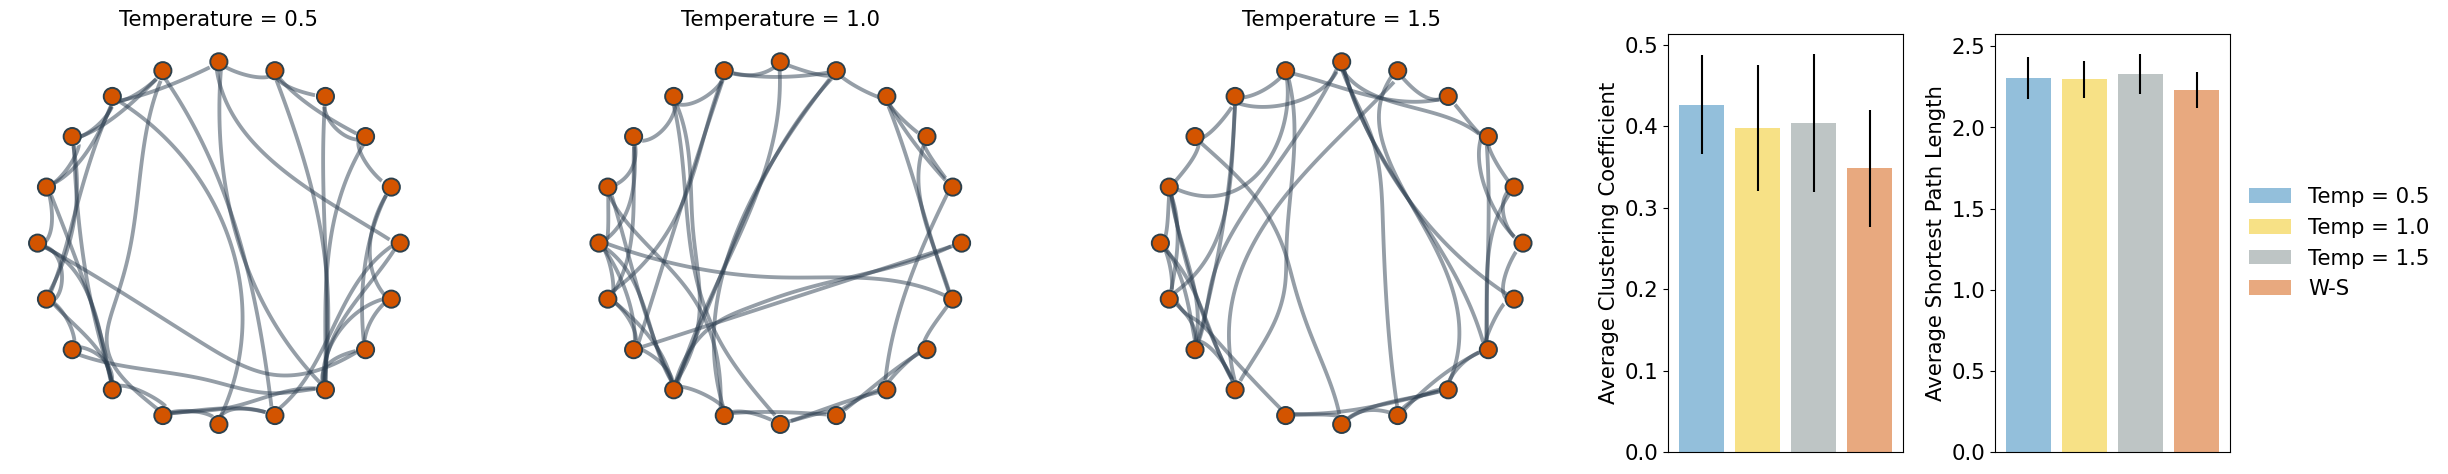

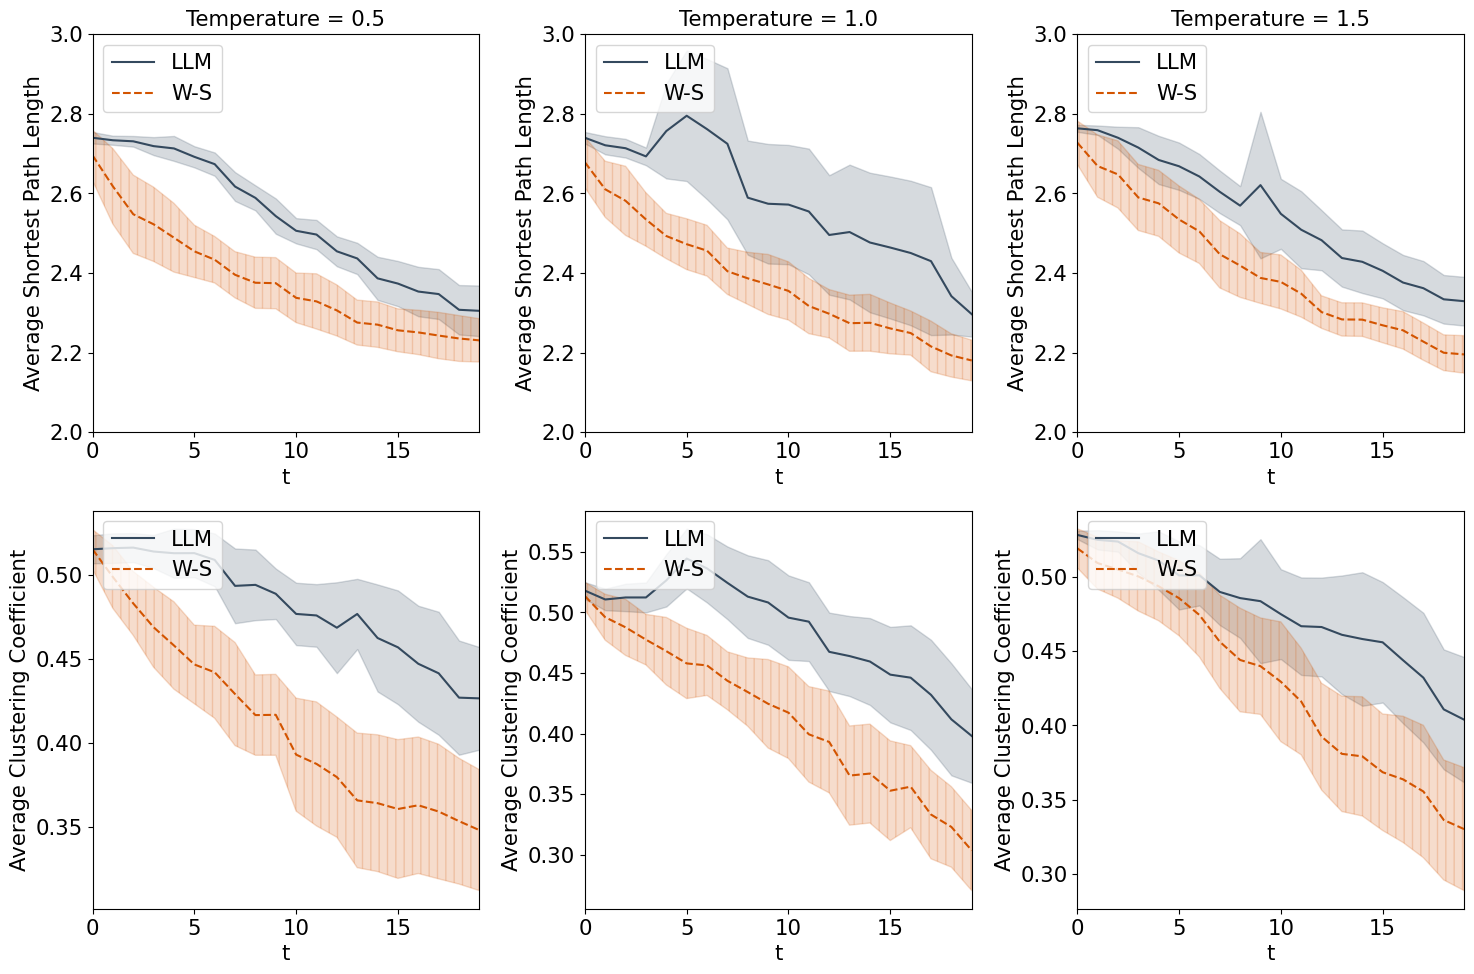

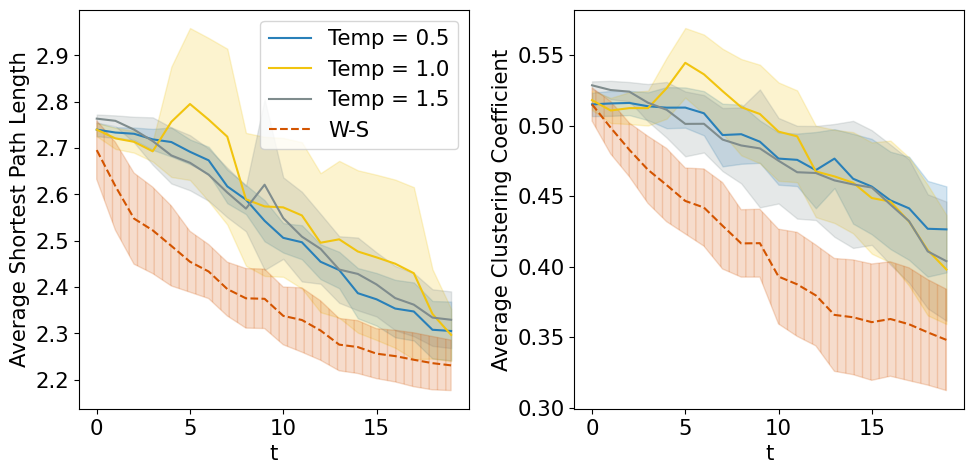

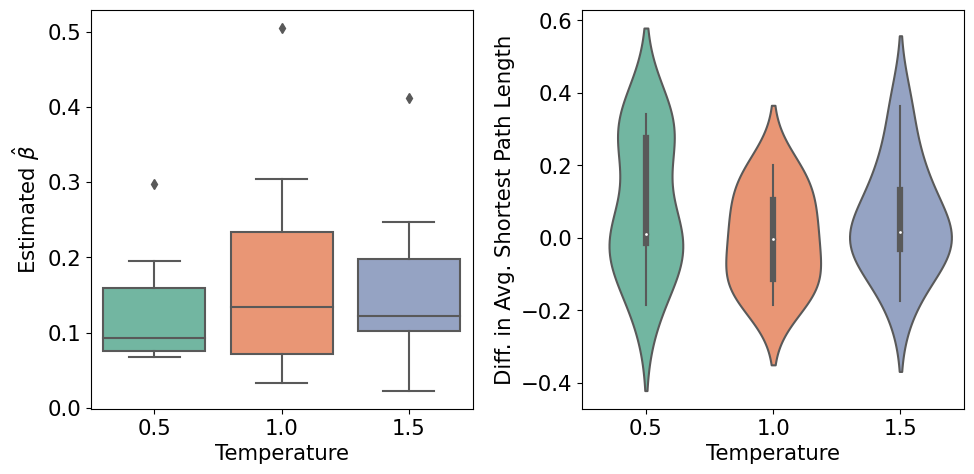

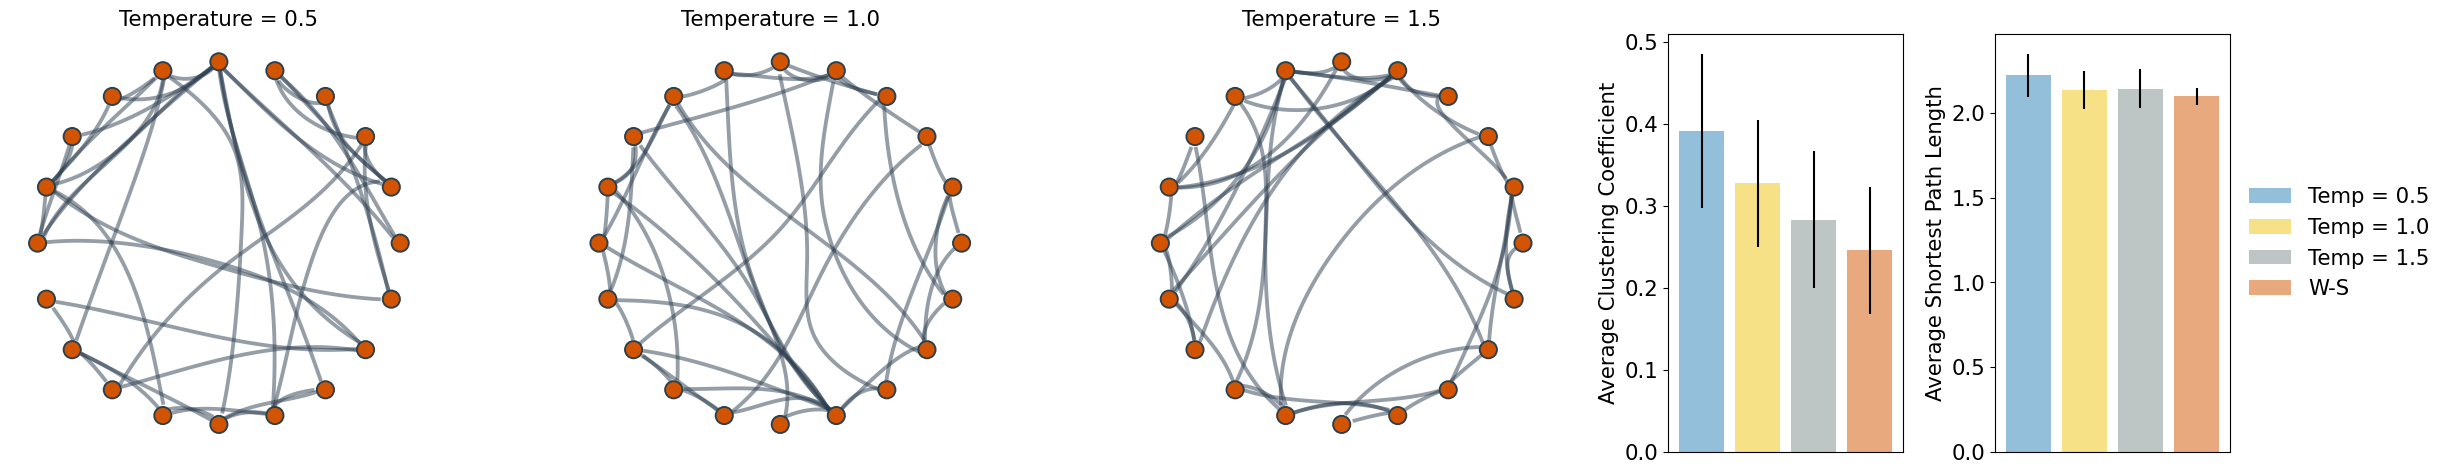

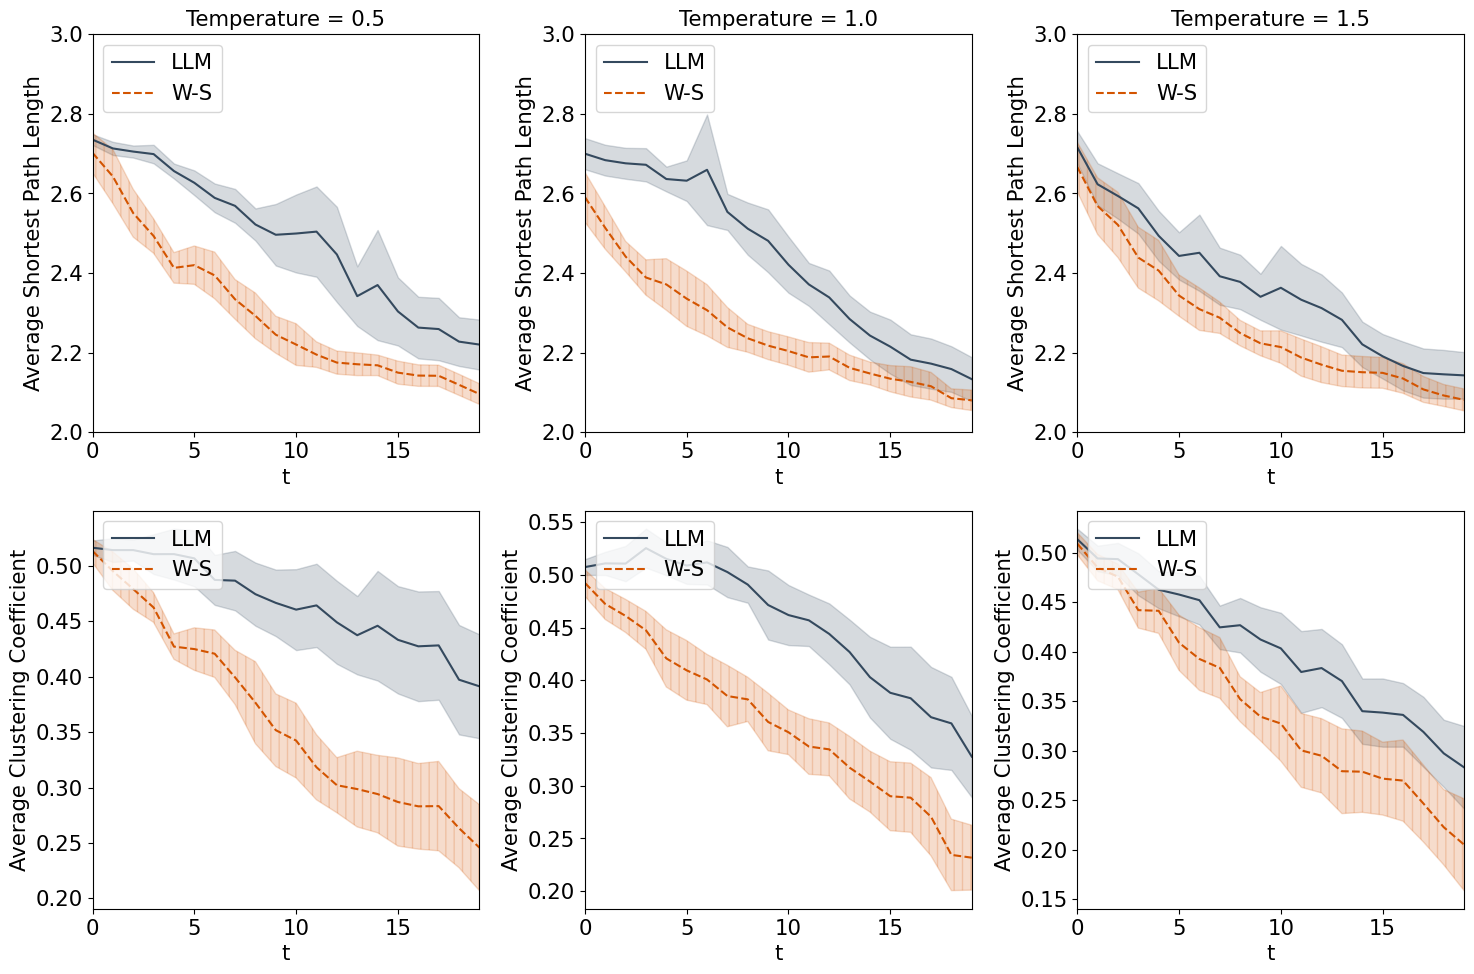

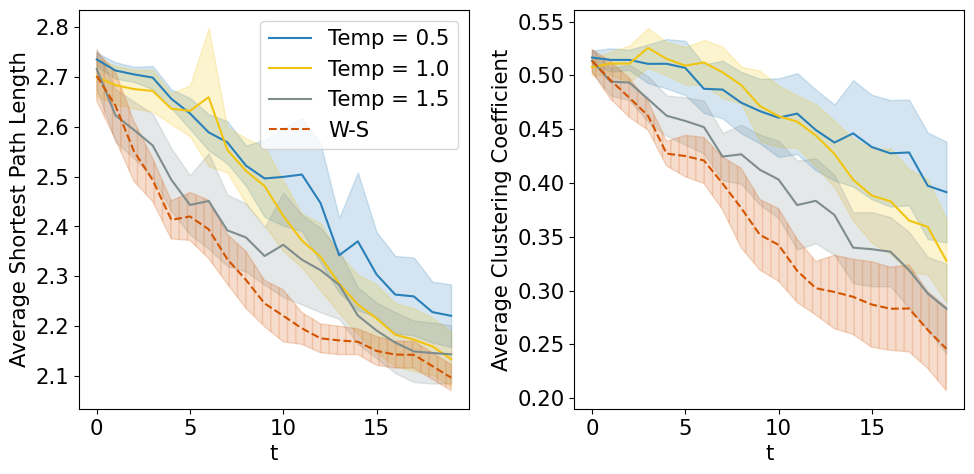

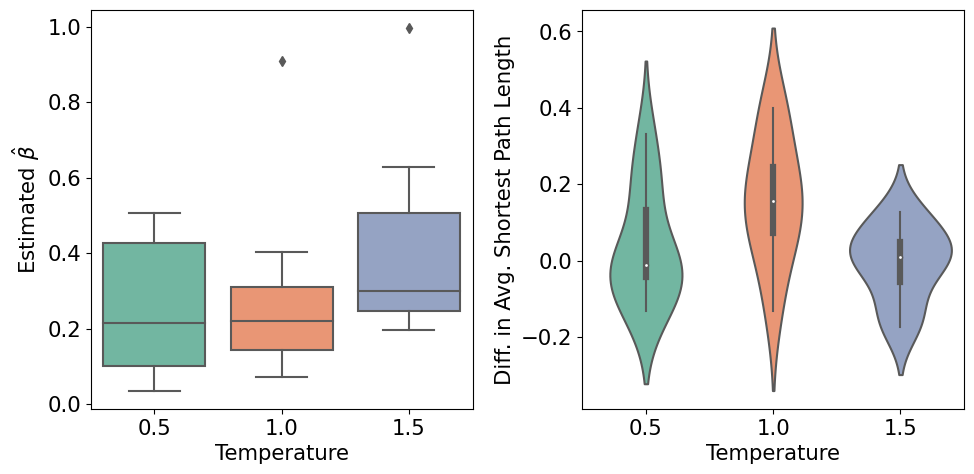

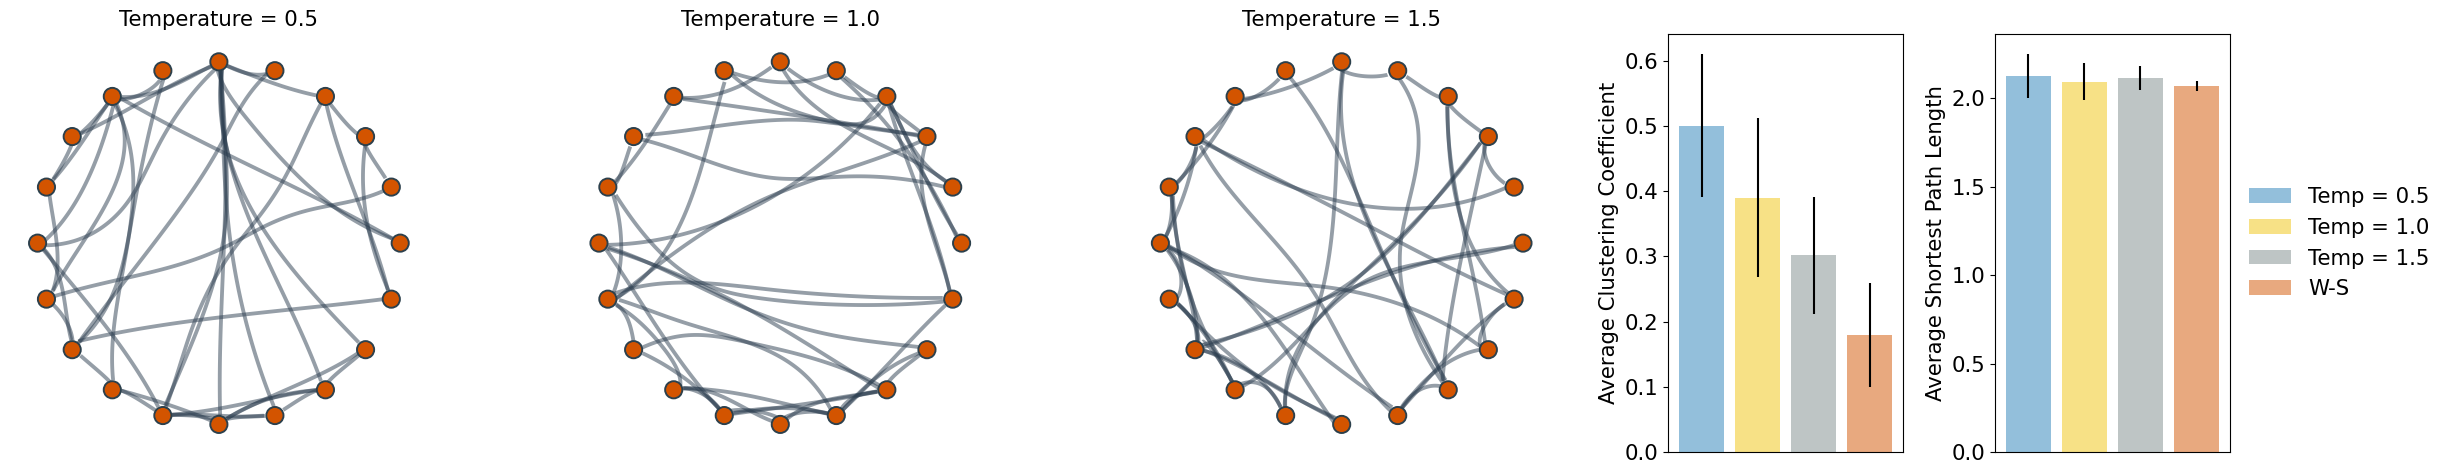

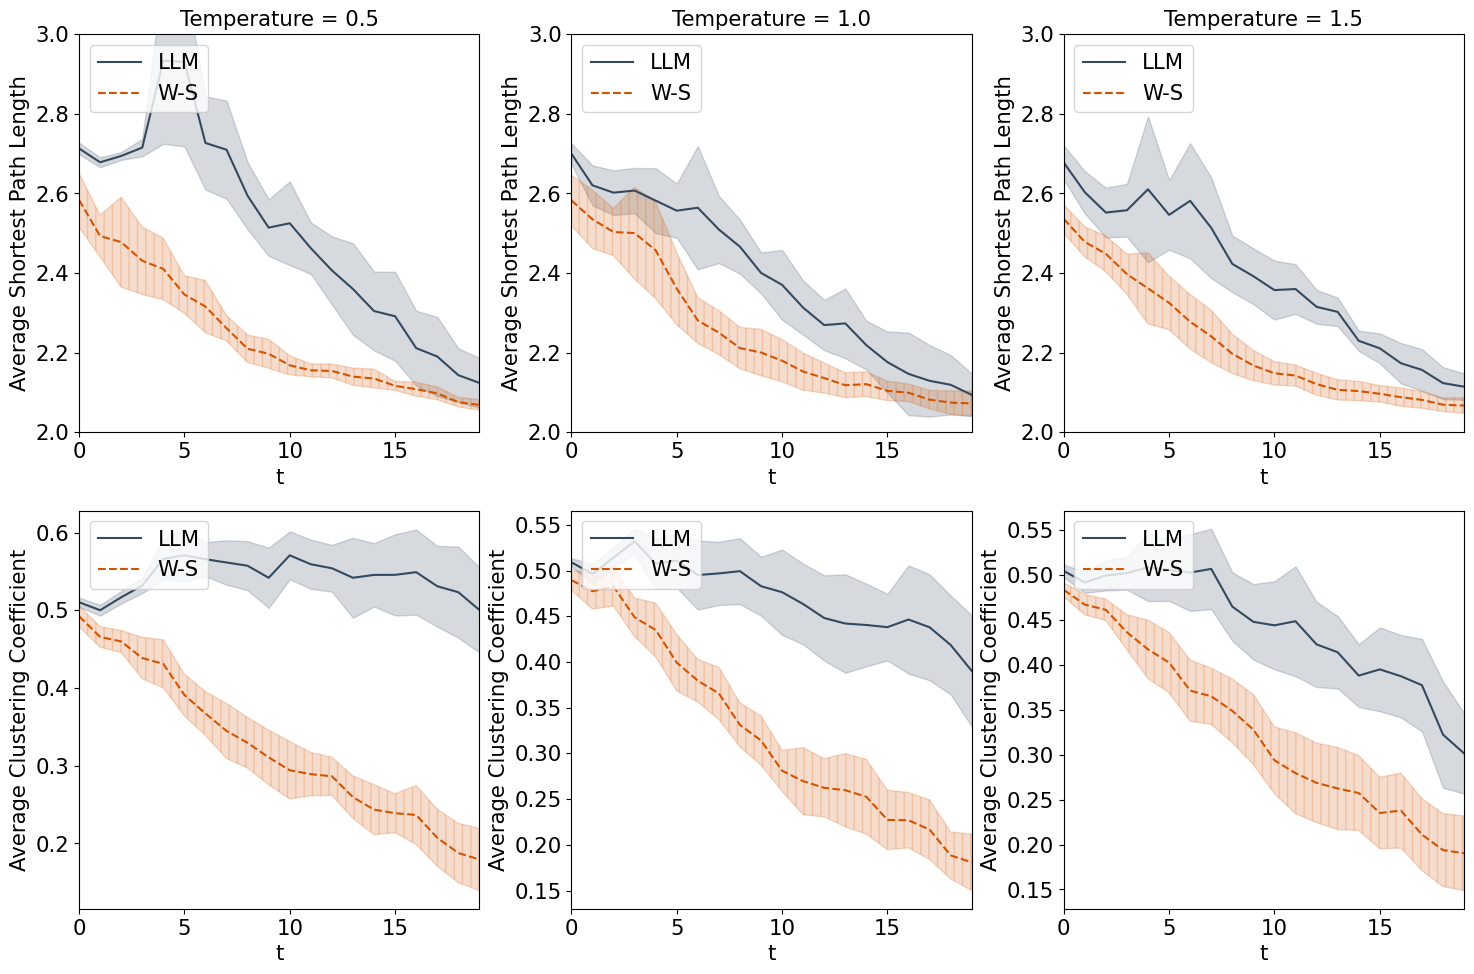

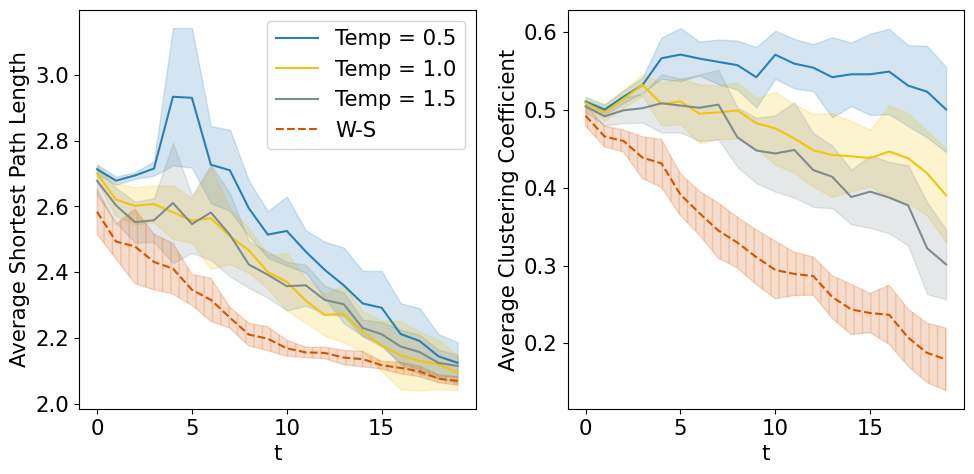

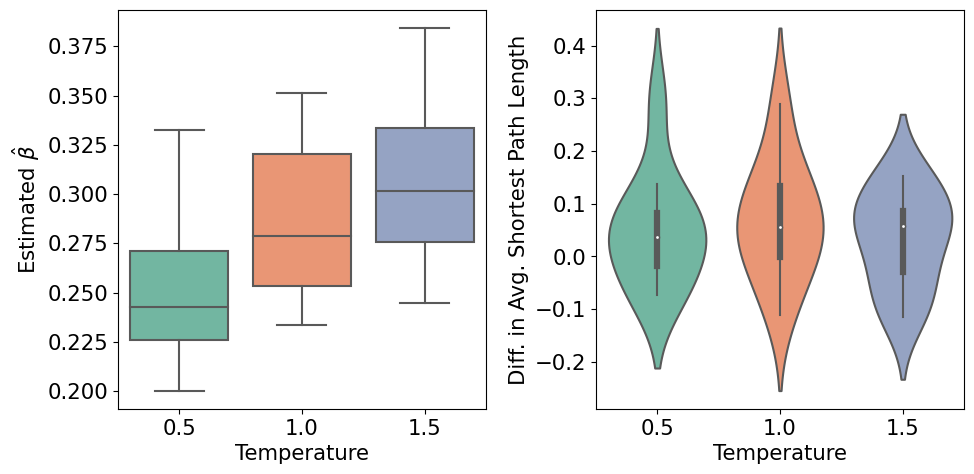

In [2]:
# LLM-based

for i, beta in enumerate([0.25, 0.5, 0.75], 1):

    run_network_formation_experiment(20, 20, 1, 5, beta, 10, f'outputs/principle_4_{i}.jsonl', [0.5, 1.0, 1.5], method='llm')
    analyze_experiments(f'outputs/principle_4_{i}.jsonl', fit_beta_method='binary_search' if beta != 0.75 else 'closed_form')

    # run_network_formation_experiment(10, 100, 10, 5, beta, 1, f'outputs/principle_4_multiple_{i}.jsonl', [0.5, 1.0, 1.5], method='llm')
    # plot_multiple_networks_small_world(f'outputs/principle_4_multiple_{i}.jsonl', f'figures/principle_4/principle_4_small_world_{i}.png')


In [ ]:
# categories = [{'category': 'Large circle', 'description': 'People who have a large number of friends and are connected to many other people in the network.'}, 
#               {'category': 'Mutual friends', 'description': 'People who have many common friends with the person making the selection.'}]

# summarize_reasons('outputs/principle_4.jsonl', categories=categories)

: 